# Setting up Pipeline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The full ImageNet dataset has about 14 million images and ~22,000 categories but it is very noisy, imbalanced, and has a number of other issues.

The version of ImageNet we'll be using has 1.2 million images and 1,000 classes (known as the competition/2012/ILSVRC2012 version, it is the most common subset to use). It still has lots of issues but it's more practical to train on.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/colab_files/imagenet64

imagenet64.tar


In [ ]:
import os
import shutil
if not os.path.exists('imagenet64'):
  if not os.path.exists(checkpoints + 'imagenet64.tar'):
    print("Downloading archive...")
    os.chdir(checkpoints)
    !wget https://pjreddie.com/media/files/imagenet64.tar
    os.chdir('/content/')
  print("Copying to local runtime...")
  shutil.copy(checkpoints + 'imagenet64.tar', './imagenet64.tar')
  print("Uncompressing...")
  !tar -xf imagenet64.tar
print("Data ready!")

Data ready!


In [ ]:
train_bz = 128
test_bz = 64

In [ ]:
def ImageNetTransformed():
  
  transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])

  trainset = torchvision.datasets.ImageFolder(root='./imagenet64/train/', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_bz, shuffle=True, num_workers=2)

  testset = torchvision.datasets.ImageFolder(root='./imagenet64/val/', transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=test_bz, shuffle=False, num_workers=2)

  return {'train': trainloader, 'test': testloader}

data = ImageNetTransformed()

In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([128, 3, 224, 224])
torch.Size([3, 224, 224])
96


In [ ]:
def imshow(img, title, sz):
    npimg = img.numpy()
    plt.figure(figsize=(sz, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def DisplayBatchImages(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images[:4])
    imshow(img, title=[str(x.item()) for x in labels[:4]],sz = 4)

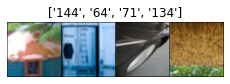

In [ ]:
DisplayBatchImages(data['train'])

In [20]:
input1 = 3
input2 = 3
input3 = [[10,20,30],[30,40,50],[60,10,5]]

In [32]:
i = int(input1)
j = int(input2)
z = [[0 for b in range(j)] for a in range(i)]
for a in range(i):
    for b in range(j):
        z[a][b] += input3[a][b]
temp = [0 for b in range(j)]
for b in range(j):
    for a in range(i):
        temp[b] += z[a][b]
col = temp.index(min(temp))

z_ = [0 for b in range(j-1)]
for a in range(i):
    for b in range(j):
        if b < col:
            z_[b] += z[a][b]
        if b > col:
            z_[b-1] += z[a][b]
print(z_)

[[10, 20, 30], [30, 40, 50], [60, 10, 5]]
1
[100, 85]


In [7]:
import torch
import math
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g,requires_grad = False)
W = W/math.sqrt(27)
W.requires_grad = True
print(W.grad)

None


# ResNet

In [ ]:
class Residual50(nn.Module):
    def __init__(self,input_channels,output_channels,stride = 1):
        super(Residual50,self).__init__()
        self.ResidualBlock = nn.Sequential(
            nn.Conv2d(input_channels,input_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Conv2d(input_channels, output_channels, kernel_size=1,stride=1, padding = 0,bias  = False),
            nn.BatchNorm2d(output_channels)
        )
        self.relu = nn.ReLU
    
    def forward(self,x):
        residual = x.clone() 
        x = self.ResidualBlock(x)
        x += residual
        x = self.relu(x)
        return x

In [ ]:
class Residual(nn.Module):
    def __init__(self,input_channels,output_channels,stride = 1):
        super(Residual,self).__init__()
        self.ResidualLastBlock = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
        )
        self.ResidualOtherBlock = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(),
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
        )
        self.relu = nn.ReLU
    
    def forward(self,x):
        residual = x.clone()
        x = self.ResidualBlock(x)
        x += residual
        x = self.relu(x)
        return x

In [ ]:
class NonResidual(nn.Module):
    def __init__(self,input_channels,output_channels,stride = 1):
        super(NonResidual,self).__init__()
        self.NonResidualBlock = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=7, stride=stride, padding=3, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=stride, padding=1)
        )
    
    def forward(self,x):
        x = self.NonResidualBlock(x)
        print("Non Residual Block is executed")
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self,Residual,NonResidual):
        super(ResNet,self).__init__()
        self.nonResidualLayer = self.createLayers(NonResidual,1,3,64,2)
        self.residualLayer1 = self.createLayers(Residual,3,64,128,2)
        self.residualLayer2 = self.createLayers(Residual,4,128,256,2)
        self.residualLayer3 = self.createLayers(Residual,6,256,512,2)
        self.residualLayer4 = self.createLayers(Residual,3,512,512,2) # Output ---> 7 x 7 x 512
        self.avgpool = nn.AvgPool2d(kernel_size = 5,stride = 1) # ----> 3 x 3 x 512
        self.classifier = nn.Sequential(
            nn.flatten(),
            nn.Linear(4608,1000)
        )

    def createLayers(self,name,num_layers,in_sz,out_sz,stride):
        layers = []
        for i in range(num_layers):
            layers.append(name(in_sz,out_sz,stride))
        return layers
    
    def forward(self,x):
        x 